**Financial Econometrics** \\
**Codes for Specifying and Estimating a VECM Model**

**Organizing Data**

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.fred import FredReader
from scipy.stats import f

In [ ]:
url = "https://www.customs.go.jp/toukei/suii/html/data/d41ma.csv"
df= pd.read_csv(url, encoding='ISO-8859-1', header = 2).dropna()

df['Exp-Total'] = df['Exp-Total']/1000000
df['Imp-Total'] = df['Imp-Total']/1000000

df['Years/Months'] = pd.to_datetime(df['Years/Months'], format='%Y/%m')
df.rename(columns={'Years/Months': 'Date'}, inplace= True)

df = df[(df['Exp-Total'] != 0) & (df['Imp-Total'] != 0)]

df.reset_index(drop=True, inplace=True)
df

,Date,Exp-Total,Imp-Total
0,1979-01-01,1192.541404,1476.341312
1,1979-02-01,1547.063623,1474.768659
2,1979-03-01,1924.706473,1729.013255
3,1979-04-01,1674.210856,1754.000207
4,1979-05-01,1795.127553,1971.518433
...,...,...,...
543,2024-04-01,8980.075715,9451.403119
544,2024-05-01,8276.854693,9499.896991
545,2024-06-01,9209.062240,8989.641078
546,2024-07-01,9612.707031,10246.964220


In [ ]:
fred_indicators = ['JPNNGDP'] # GDP
df_gdp = FredReader(symbols=fred_indicators, start='1900', end=None).read()

rename_dict = {'JPNNGDP':'GDP'}
df_gdp = df_gdp.rename(columns=rename_dict)
df_gdp.head()

# Create a new monthly index from the start to the end of the quarterly data
monthly_index = pd.date_range(start=df_gdp.index.min(), end=df_gdp.index.max() + pd.offsets.MonthEnd(0), freq='M')
df_gdp_monthly = pd.DataFrame(index=monthly_index)

# Assign quarterly values to the corresponding months, dividing by 3 to start
for quarter_start in df_gdp.index:
    quarter_value = df_gdp.loc[quarter_start, 'GDP']
    # Assign one-third to each of the three months of the quarter
    df_gdp_monthly.loc[quarter_start:quarter_start + pd.offsets.MonthEnd(2), 'GDP'] = quarter_value / 3

# Interpolate the monthly values to create a smooth trend
df_gdp_monthly['GDP'] = df_gdp_monthly['GDP'].interpolate(method='linear')

# Print the resulting monthly GDP DataFrame
df_gdp_monthly.index = df_gdp_monthly.index.to_period('M').to_timestamp()
df_gdp_monthly.reset_index(inplace=True)

df_gdp_monthly.rename(columns={'index': 'Date'}, inplace=True)
df_gdp_monthly

<ipython-input-42-c4e55e7b1f18>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_index = pd.date_range(start=df_gdp.index.min(), end=df_gdp.index.max() + pd.offsets.MonthEnd(0), freq='M')


,Date,GDP
0,1994-01-01,170043.766667
1,1994-02-01,170043.766667
2,1994-03-01,169858.766667
3,1994-04-01,169673.766667
4,1994-05-01,169673.766667
...,...,...
359,2023-12-01,199291.300000
360,2024-01-01,199044.000000
361,2024-02-01,199044.000000
362,2024-03-01,200839.283333


In [ ]:
fred_indicators = ['EXJPUS'] # Exchange rate

df_r= FredReader(symbols=fred_indicators, start='1900', end=None).read()

rename_dict = {'EXJPUS':'R'}

df_r= df_r.rename(columns=rename_dict)
df_r.reset_index(inplace=True)
df_r.rename(columns={'DATE': 'Date'}, inplace=True)
df_r

,Date,R
0,1971-01-01,358.0200
1,1971-02-01,357.5450
2,1971-03-01,357.5187
3,1971-04-01,357.5032
4,1971-05-01,357.4130
...,...,...
640,2024-05-01,155.8691
641,2024-06-01,157.8600
642,2024-07-01,157.5182
643,2024-08-01,146.2641


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/My Drive/Financial_Econometrics')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['International merchandise trade OECD.csv',
 'Quarterly GDP growth OECD.csv',
 'fdi_inward_japan.csv',
 'fdi_outward_japan.csv']

In [ ]:
inf_path = '/content/drive/My Drive/Financial_Econometrics/fdi_inward_japan.csv'
inf = pd.read_csv(inf_path, header = 27)
inf.rename(columns={'Unnamed: 3': 'Month', 'Unnamed: 2': 'Year', 'Net':'Inflow'}, inplace= True)
inf = inf[['Month','Year','Inflow']]

inf['Year'].fillna(method='ffill', inplace=True)
inf['Year'] = inf['Year'].astype(int)
inf['Month'] = inf['Month'].str.extract(r'([A-Za-z]+)')
inf['Date'] = pd.to_datetime(inf['Year'].astype(str) + '-' + inf['Month'])
inf.drop(columns=['Year', 'Month'], inplace=True)

out_path = '/content/drive/My Drive/Financial_Econometrics/fdi_outward_japan.csv'
out = pd.read_csv(out_path, header = 27, encoding='ISO-8859-1')
out.rename(columns={'Unnamed: 3': 'Month', 'Unnamed: 2': 'Year', 'Net':'Outflow'}, inplace= True)
out = out[['Month','Year','Outflow']]

out['Year'].fillna(method='ffill', inplace=True)
out['Year'] = out['Year'].astype(int)
out['Month'] = out['Month'].str.extract(r'([A-Za-z]+)')
out['Date'] = pd.to_datetime(out['Year'].astype(str) + '-' + out['Month'])
out.drop(columns=['Year', 'Month'], inplace=True)
fdi = out.merge(inf, on= "Date")
fdi.head()

<ipython-input-45-3570c492ebe5>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inf['Year'].fillna(method='ffill', inplace=True)
<ipython-input-45-3570c492ebe5>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  inf['Year'].fillna(method='ffill', inplace=True)
<ipython-input-45-3570c492ebe5>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as

,Outflow,Date,Inflow
0,"1,673",1996-01-01,-78
1,"4,009",1996-02-01,140
2,"2,293",1996-03-01,75
3,"2,765",1996-04-01,"-2,034"
4,"2,598",1996-05-01,706


In [ ]:
df_all = df.merge(df_gdp_monthly, on='Date').merge(df_r, on='Date')#.merge(fdi, on = 'Date')
df_all.set_index('Date', inplace=True)
df_all

,Exp-Total,Imp-Total,GDP,R
Date,,,,
1994-01-01,2906.853119,2228.338869,170043.766667,111.4415
1994-02-01,3224.979018,2041.913309,170043.766667,106.3011
1994-03-01,3839.527713,2378.333198,169858.766667,105.0974
1994-04-01,3438.461872,2280.632270,169673.766667,103.4843
1994-05-01,2900.692807,2226.359910,169673.766667,103.7533
...,...,...,...,...
2023-12-01,9642.926012,9584.044267,199291.300000,143.9815
2024-01-01,7332.754388,9099.294967,199044.000000,146.2943
2024-02-01,8249.204131,8632.181545,199044.000000,149.6150


**Take the Natural Logarithmic Form**

In [ ]:
df_all[['GDP', 'Exp-Total', 'Imp-Total']] = df_all[['GDP', 'Exp-Total', 'Imp-Total']].apply(np.log)
df_all.head()

,Exp-Total,Imp-Total,GDP,R
Date,,,,
1994-01-01,7.974826,7.709012,12.043811,111.4415
1994-02-01,8.078682,7.621643,12.043811,106.3011
1994-03-01,8.253105,7.774155,12.042723,105.0974
1994-04-01,8.142780,7.732208,12.041633,103.4843
1994-05-01,7.972705,7.708123,12.041633,103.7533


**Checking for Stationarity: ADF Test**

In [ ]:
def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")

    if isinstance(df, pd.Series):
        df = df.to_frame()

    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)

        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)

def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names

In [ ]:
ADF_test_summary(df_all, missing='drop')

                                                  Exp-Total                                                   
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.095         -3.354        0.058         17    -3.985      -3.423     -3.135
	Constant             0.784          3.373        0.001
	Trend                0.000          2.949        0.003
Constant Only               -0.014         -1.117        0.708         15    -3.449      -2.870     -2.571
	Constant             0.125          1.161        0.246
No Constant                  0.001          1.638        0.976         15    -2.572      -1.942     -1.616
                                                  Imp-Total                                                   
Specification               Coeff          Statistic     P-value      La

The ADF is used to test the stationarity of a time series, by identifing the presence of a unit root. A unit root imply non-stationarity.

H0: The time series has a unit root

H1: The time series is stationary

For all variables we fail to reject the null hypothesis.

**Detrending**

In [ ]:
# Differencing to remove trend
df_all_diff = pd.DataFrame()

df_all_diff['GDP'] = df_all['GDP'].diff()
df_all_diff['Exp-Total'] = df_all['Exp-Total'].diff()
df_all_diff['Imp-Total'] = df_all['Imp-Total'].diff()
df_all_diff['R'] = df_all['R'].diff()

# Drop the first row since differencing creates NaN
df_all.dropna(inplace=True)

In [ ]:
ADF_test_summary(df_all_diff, missing='drop')

                                                     GDP                                                      
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.474         -6.560        0.000          4    -3.984      -3.423     -3.134
	Constant            -0.000         -0.346        0.729
	Trend                0.000          1.039        0.300
Constant Only               -0.465         -6.480        0.000          4    -3.449      -2.870     -2.571
	Constant             0.000          1.089        0.277
No Constant                 -0.452         -6.387        0.000          4    -2.572      -1.942     -1.616
                                                  Exp-Total                                                   
Specification               Coeff          Statistic     P-value      La

**VAR Model**

In [ ]:
# Create the VAR model
model = VAR(df_all)

# Use select_order to find the optimal lag length based on AIC, BIC, HQIC, or FPE
lag_selection = model.select_order(maxlags=10)  # Adjust `maxlags` based on your data
print(lag_selection.summary())

# Access the optimal lags based on AIC and BIC
optimal_lag_aic = lag_selection.aic
optimal_lag_bic = lag_selection.bic

print(f'Optimal Lag Length (AIC): {optimal_lag_aic}')
print(f'Optimal Lag Length (BIC): {optimal_lag_bic}')

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -8.843      -8.799   0.0001444      -8.825
1       -18.64      -18.42   8.040e-09      -18.55
2       -19.57      -19.18   3.153e-09      -19.42
3       -20.07     -19.50*   1.929e-09      -19.84
4       -20.18      -19.44   1.715e-09      -19.89
5       -20.29      -19.37   1.540e-09      -19.93
6       -20.37      -19.27   1.431e-09     -19.93*
7       -20.37      -19.10   1.427e-09      -19.86
8       -20.34      -18.90   1.467e-09      -19.77
9       -20.34      -18.73   1.464e-09      -19.70
10     -20.49*      -18.70  1.263e-09*      -19.78
--------------------------------------------------
Optimal Lag Length (AIC): 10
Optimal Lag Length (BIC): 3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Prepare the data by selecting the relevant columns
df_var = df_all[['GDP', 'R', 'Exp-Total', 'Imp-Total']]

# Fit the VAR model
model = VAR(df_all)
results = model.fit(maxlags=3)  # You can choose the optimal number of lags using model.select_order()

# Print a summary of the results
print(results.summary())

# Make forecasts
lag_order = results.k_ar
forecast_input = df_all.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=5)

# Convert forecast to a DataFrame for better readability
forecast_df = pd.DataFrame(forecast, columns=['GDP', 'R', 'Exp-Total', 'Imp-Total'])
print(forecast_df)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     15:57:32
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -19.5454
Nobs:                     361.000    HQIC:                  -19.8829
Log likelihood:           1632.12    FPE:                1.85479e-09
AIC:                     -20.1056    Det(Omega_mle):     1.61004e-09
--------------------------------------------------------------------
Results for equation Exp-Total
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.489588         2.202619           -0.222           0.824
L1.Exp-Total         0.375362         0.050852            7.381           0.000
L1.Imp-Total         0.155722         0.089826            1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Cointegration Test**

In [ ]:
# Perform the Johansen cointegration test
coint_test = coint_johansen(df_var, det_order=0, k_ar_diff=1)

# Print the test results
print("Eigenvalue Test Statistic:")
print(coint_test.lr1)  # Trace statistic for each hypothesis

print("\nCritical Values (90%, 95%, 99%):")
print(coint_test.cvt)  # Critical values for trace statistics

# Optional: print a summary of the results
eigenvalue_results = pd.DataFrame({
    'Test Statistic': coint_test.lr1,
    '90% Critical Value': coint_test.cvt[:, 0],
    '95% Critical Value': coint_test.cvt[:, 1],
    '99% Critical Value': coint_test.cvt[:, 2]
})

print("\nJohansen Cointegration Test Results:")
print(eigenvalue_results)

Eigenvalue Test Statistic:
[147.70002329  34.53384679   7.68307306   0.94497044]

Critical Values (90%, 95%, 99%):
[[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Johansen Cointegration Test Results:
   Test Statistic  90% Critical Value  95% Critical Value  99% Critical Value
0      147.700023             44.4929             47.8545             54.6815
1       34.533847             27.0669             29.7961             35.4628
2        7.683073             13.4294             15.4943             19.9349
3        0.944970              2.7055              3.8415              6.6349


# Based on the test results, we reject the null hypothesis up to r ≤ 1, indicating that there are at least two cointegration relationships among the variables in your dataset. This suggests that there are long-term equilibrium relationships between the variables: GDP, R, Exp-Total, and Imp-Total.

**VECM**

In [ ]:
# Step 2: Define the lag order and determine the cointegration rank from the Johansen test
lag_order = 3  # Replace with the appropriate number of lags you determined earlier
coint_rank = 2  # Based on the Johansen test results you interpreted

# Step 3: Fit the VECM model
vecm_model = VECM(df_var, k_ar_diff=lag_order, coint_rank=coint_rank, deterministic='ci')
vecm_fit = vecm_model.fit()

# Step 4: Display the VECM results
print(vecm_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.GDP           0.7571      0.052     14.445      0.000       0.654       0.860
L1.R         -8.476e-06   8.05e-05     -0.105      0.916      -0.000       0.000
L1.Exp-Total     0.0071      0.004      1.639      0.101      -0.001       0.016
L1.Imp-Total     0.0098      0.004      2.331      0.020       0.002       0.018
L2.GDP          -0.5440      0.058     -9.353      0.000      -0.658      -0.430
L2.R         -8.484e-05   9.08e-05     -0.934      0.350      -0.000    9.32e-05
L2.Exp-Total    -0.0026      0.004     -0.684      0.494      -0.010       0.005
L2.Imp-Total     0.0131      0.005      2.648      0.008       0.003       0.023
L3.GDP           0.2078      0.052      3.967      0.000       0.105       0.311
L3.R         -8.146e-05   

**Variance Decomposition Analysis**

In [ ]:
# Step 1: Fit the VAR model using the same data and lag order from VECM
lag_order = vecm_model.k_ar  # Number of lags used in your VECM model
var_model = VAR(df_var)
var_results = var_model.fit(lag_order)

# Step 2: Perform Variance Decomposition
steps = 10  # Specify the number of periods for which you want to forecast
fevd = var_results.fevd(steps)

# Step 3: Print the FEVD results
endog_names = var_results.model.endog_names  # Get endogenous variable names
for i in range(len(fevd.decomp)):
    print(f"Variance Decomposition for {endog_names[i]}:")
    print(fevd.decomp[i])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Variance Decomposition for GDP:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.88861761e-01 9.28241987e-04 2.84978962e-04 9.92501838e-03]
 [9.64447231e-01 4.83531985e-03 1.20166481e-03 2.95157843e-02]
 [9.43294374e-01 9.57292244e-03 1.22989664e-03 4.59028069e-02]
 [9.26753284e-01 1.39876021e-02 1.29955888e-03 5.79595548e-02]
 [9.11443578e-01 1.84682034e-02 3.06007981e-03 6.70281390e-02]
 [8.95040328e-01 2.27099388e-02 6.60922447e-03 7.56405092e-02]
 [8.78621165e-01 2.63760693e-02 1.00941907e-02 8.49085753e-02]
 [8.62968232e-01 2.93111046e-02 1.41606738e-02 9.35599891e-02]
 [8.48204192e-01 3.13267799e-02 1.92405828e-02 1.01228445e-01]]
Variance Decomposition for R:
[[1.31220483e-03 9.98687795e-01 0.00000000e+00 0.00000000e+00]
 [1.77784822e-03 9.94635044e-01 3.56596573e-03 2.11420274e-05]
 [2.13206427e-03 9.88012362e-01 9.06111303e-03 7.94460905e-04]
 [1.97643865e-03 9.77493483e-01 1.94108428e-02 1.11923528e-03]
 [2.07667907e-03 9.64224009e-01 3.17972416e-02 1.902069

GDP shows increasing influence from imports and exports over time, suggesting that these factors have a growing role in explaining GDP fluctuations.
R is largely self-driven, with little influence from other variables.
Exp-Total maintains a significant share of its own variance, with some contribution from R and Imp-Total.
Imp-Total is primarily influenced by itself but has notable contributions from GDP and exports.

**Granger Causality Test**

In [ ]:
# Perform the Granger causality test
# Here, we check if 'R' Granger-causes 'GDP'
# You can change the variable names and the max_lag as needed
max_lag = 3  # Number of lags to consider
granger_result = grangercausalitytests(df_var[['GDP', 'R']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0111  , p=0.3153  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=1.0195  , p=0.3126  , df=1
likelihood ratio test: chi2=1.0181  , p=0.3130  , df=1
parameter F test:         F=1.0111  , p=0.3153  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8021  , p=0.0620  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=5.6827  , p=0.0583  , df=2
likelihood ratio test: chi2=5.6386  , p=0.0596  , df=2
parameter F test:         F=2.8021  , p=0.0620  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3636  , p=0.2537  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=4.1716  , p=0.2435  , df=3
likelihood ratio test: chi2=4.1477  , p=0.2459  , df=3
parameter F test:         F=1.3636  , p=0.2537  , df_denom=354, df_num=3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Overall, across the tested lags (1, 2, and 3), the evidence of Granger causality is weak.
For lag 1 and lag 3, we conclude that the lagged values do not Granger-cause the current values of the other variable, while for lag 2, there is a slight indication (p-value near 0.05) that there may be a relationship, but it is not strong enough to reject the null hypothesis.

In [ ]:
max_lag = 3  # Number of lags to consider
granger_result = grangercausalitytests(df_var[['R', 'GDP']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5892 , p=0.0012  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=10.6775 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5234 , p=0.0012  , df=1
parameter F test:         F=10.5892 , p=0.0012  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0563  , p=0.0026  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=12.2822 , p=0.0022  , df=2
likelihood ratio test: chi2=12.0784 , p=0.0024  , df=2
parameter F test:         F=6.0563  , p=0.0026  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6264  , p=0.0034  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=14.1537 , p=0.0027  , df=3
likelihood ratio test: chi2=13.8833 , p=0.0031  , df=3
parameter F test:         F=4.6264  , p=0.0034  , df_denom=354, df_num=3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Overall, across all tested lags (1, 2, and 3), there is strong evidence of Granger causality. This means that the lagged values of the first variable help predict the current values of the second variable at all tested lag lengths.
The consistently low p-values across all lags suggest a robust predictive relationship.

In [ ]:
max_lag = 3  # Number of lags to consider
granger_result = grangercausalitytests(df_var[['GDP', 'Imp-Total']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9694  , p=0.3255  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=0.9775  , p=0.3228  , df=1
likelihood ratio test: chi2=0.9762  , p=0.3231  , df=1
parameter F test:         F=0.9694  , p=0.3255  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7201  , p=0.4874  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=1.4604  , p=0.4818  , df=2
likelihood ratio test: chi2=1.4575  , p=0.4825  , df=2
parameter F test:         F=0.7201  , p=0.4874  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9601  , p=0.1196  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=5.9967  , p=0.1118  , df=3
likelihood ratio test: chi2=5.9475  , p=0.1142  , df=3
parameter F test:         F=1.9601  , p=0.1196  , df_denom=354, df_num=3


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
max_lag = 3  # Number of lags to consider
granger_result = grangercausalitytests(df_var[['Imp-Total', 'GDP']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0020  , p=0.3175  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=1.0104  , p=0.3148  , df=1
likelihood ratio test: chi2=1.0090  , p=0.3151  , df=1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



parameter F test:         F=1.0020  , p=0.3175  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1471  , p=0.1183  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=4.3544  , p=0.1134  , df=2
likelihood ratio test: chi2=4.3284  , p=0.1148  , df=2
parameter F test:         F=2.1471  , p=0.1183  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4962  , p=0.0596  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=7.6368  , p=0.0541  , df=3
likelihood ratio test: chi2=7.5571  , p=0.0561  , df=3
parameter F test:         F=2.4962  , p=0.0596  , df_denom=354, df_num=3


In [ ]:
max_lag = 3  # Number of lags to consider
granger_result = grangercausalitytests(df_var[['Exp-Total', 'GDP']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=6.9220  , p=0.0089  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=6.9797  , p=0.0082  , df=1
likelihood ratio test: chi2=6.9134  , p=0.0086  , df=1
parameter F test:         F=6.9220  , p=0.0089  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3835  , p=0.0050  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=10.9179 , p=0.0043  , df=2
likelihood ratio test: chi2=10.7565 , p=0.0046  , df=2
parameter F test:         F=5.3835  , p=0.0050  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.0314 , p=0.0000  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=36.8080 , p=0.0000  , df=3
likelihood ratio test: chi2=35.0500 , p=0.0000  , df=3
parameter F test:         F=12.0314 , p=0.0000  , df_denom=354, df_num=3


In [ ]:
max_lag = 3  # Number of lags to consider
granger_result = grangercausalitytests(df_var[['GDP', 'Exp-Total']], max_lag, verbose=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0014  , p=0.9700  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=0.0014  , p=0.9699  , df=1
likelihood ratio test: chi2=0.0014  , p=0.9699  , df=1
parameter F test:         F=0.0014  , p=0.9700  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0063  , p=0.9938  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=0.0127  , p=0.9937  , df=2
likelihood ratio test: chi2=0.0127  , p=0.9937  , df=2
parameter F test:         F=0.0063  , p=0.9938  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3599  , p=0.7820  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=1.1010  , p=0.7768  , df=3
likelihood ratio test: chi2=1.0994  , p=0.7772  , df=3
parameter F test:         F=0.3599  , p=0.7820  , df_denom=354, df_num=3


**Impulse Response Function**

In [ ]:
irf = results.irf(10)  # 10 periods for the impulse response

<Figure size 640x480 with 0 Axes>

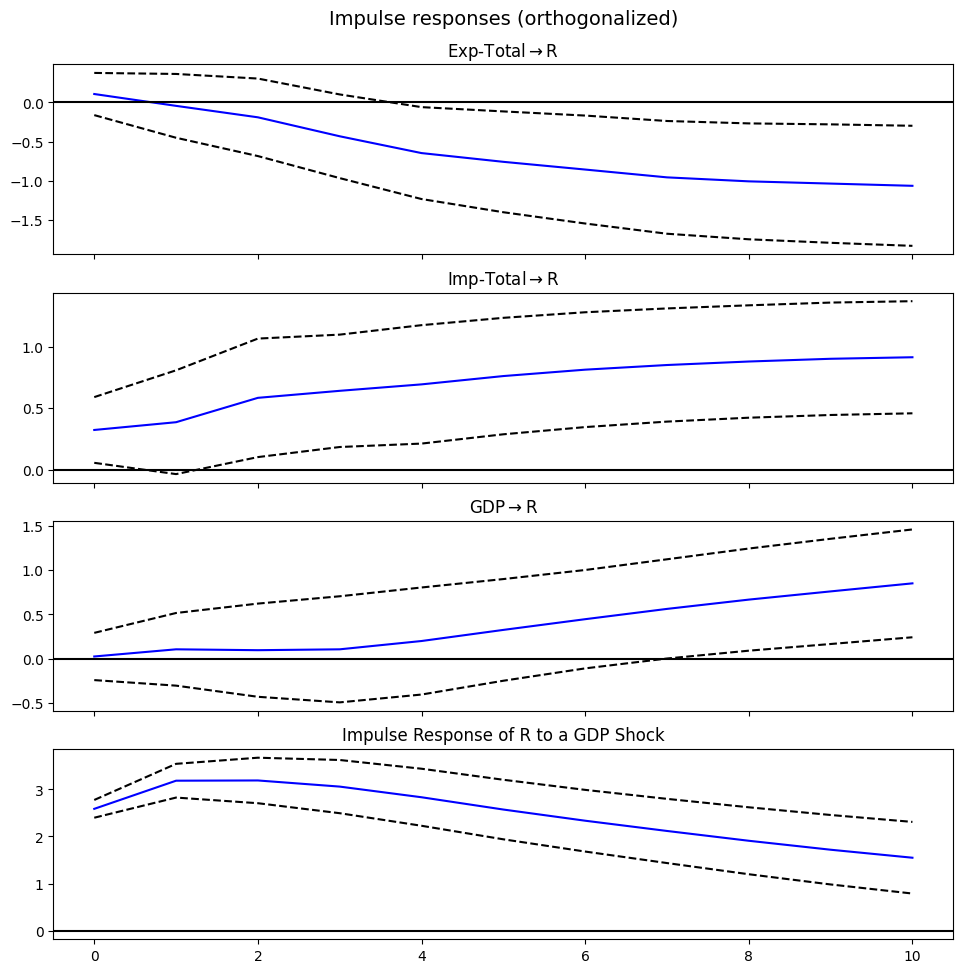

<Figure size 640x480 with 0 Axes>

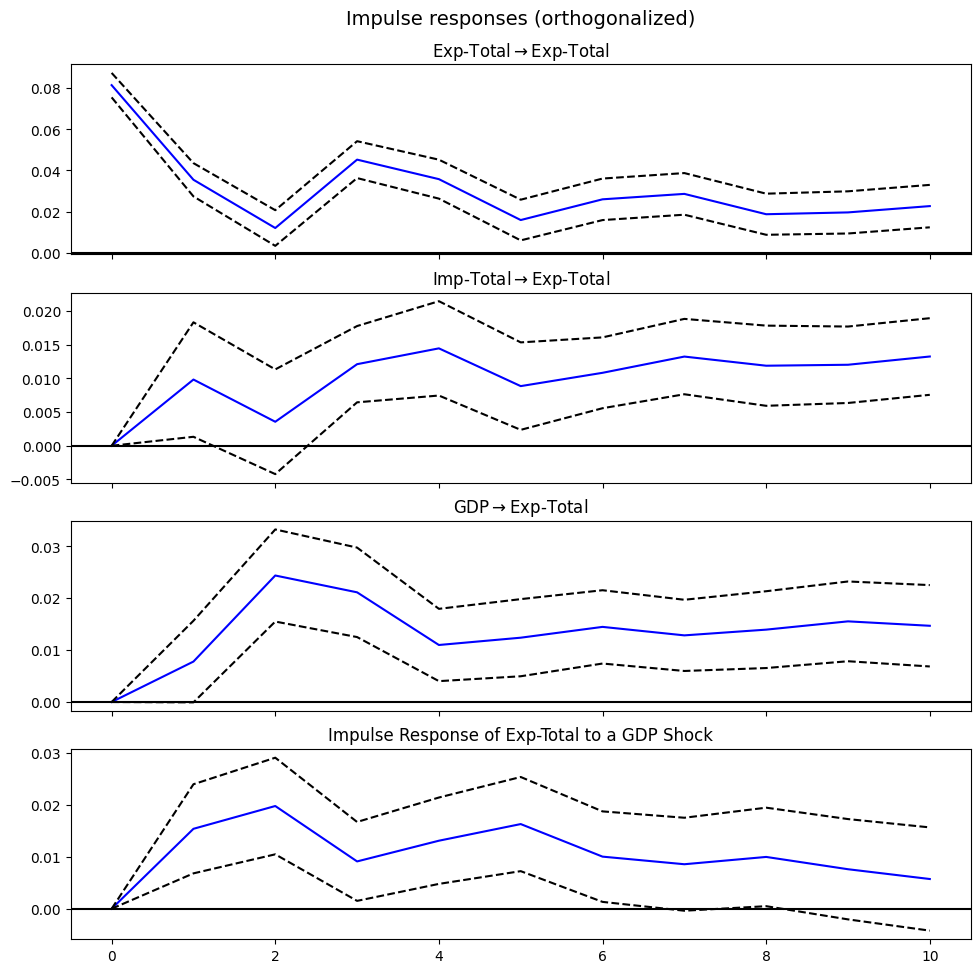

<Figure size 640x480 with 0 Axes>

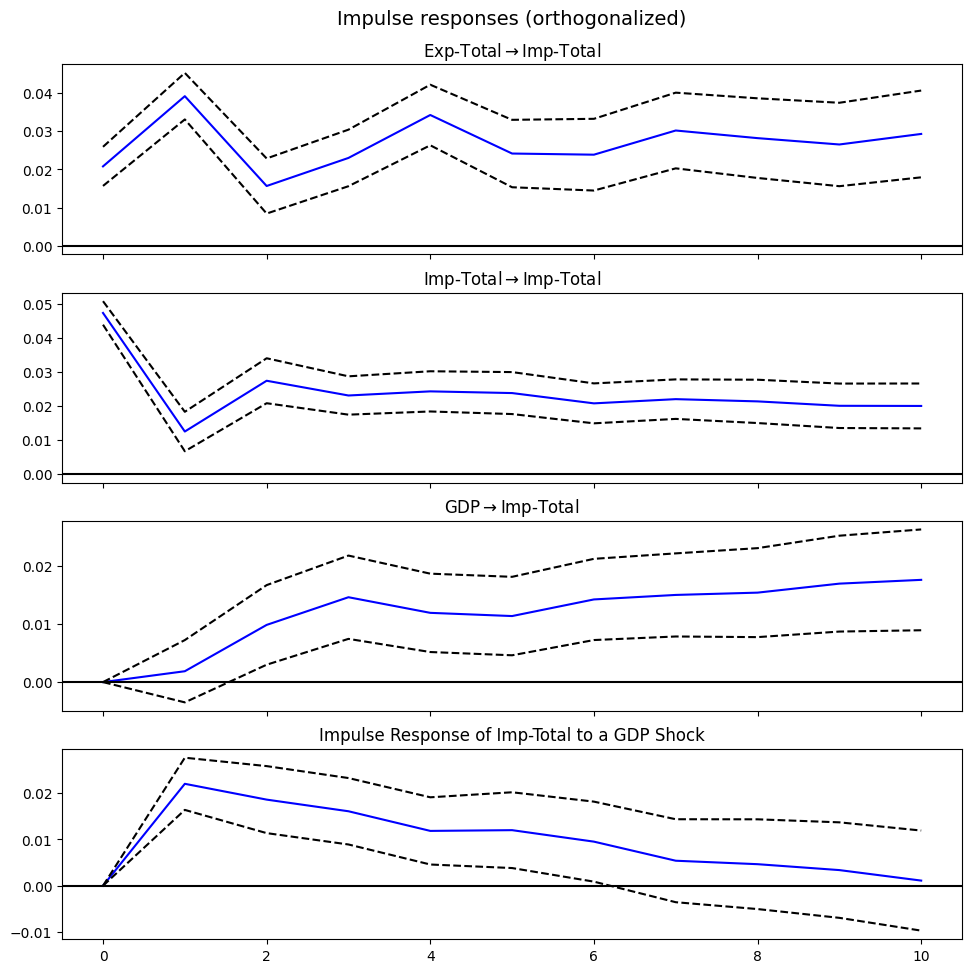

In [ ]:
# Create a list of variables
variables = ['GDP', 'R', 'Exp-Total', 'Imp-Total']

# Select the index for GDP shock
gdp_shock_index = 0  # Usually the index of GDP in the model

# Plot the responses of the other variables to a shock in GDP
for i in range(1, len(variables)):  # Starting from 1 to exclude GDP itself
    plt.figure()
    irf.plot(orth=True, response=variables[i])  # Plots only for the variable in question
    plt.title(f'Impulse Response of {variables[i]} to a GDP Shock')
    plt.show()